In [308]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

# Linkage Synthesis Challenge Problem Advanced Code
This also notebook optimizes the connectivity of the mechanims itself


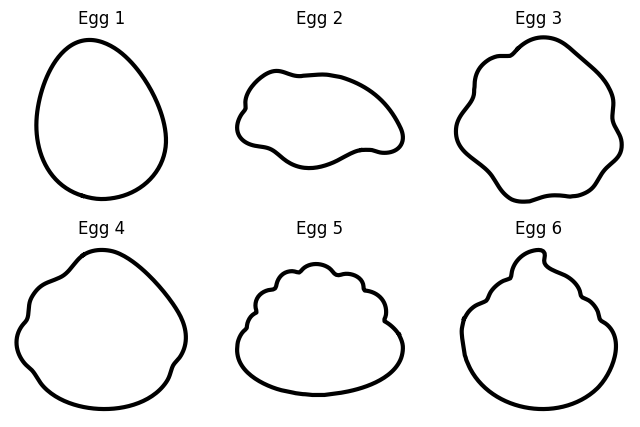

In [309]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


## GA Full Mechanism Generation
To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. As we discussed, we can replace the edges with a connectivity matrrix. We also know the connectivity matrix is symmetric (if nodes 1 and 2 are connected nodes 2 and 1 are also connected) and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix, we will only have it come up with the upper triangular half of the matrix (not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism:

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be `[1,0]`. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we have a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/constraints/index.html)) as less than or equal to zero constraints. We will set the two constraints on distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (edges, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct the mechanism using <code>convert_1D_to_mech</code>. Next, perform the same evaluations as we did in the starter notebook.
    </li>
</ul>

In [310]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

from LINKS.Optimization import DifferentiableTools, Tools, MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer, GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from LINKS.CP import make_empty_submission, evaluate_submission

In [311]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, dist=.75, mtl=10, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([dist, mtl])  # Constraints: distance <= 0.75, material <= 10.0 default


In [312]:
differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

In [313]:
initial_pop = 100
num_gens = 100
curves_to_run = [0, 1, 2, 3, 4, 5]
n=8

randomizer = MechanismRandomizer(
    min_size = 6, # smallest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

random_mechanism = randomizer()
mechanisms = [randomizer(n=n) for _ in trange(initial_pop)]
# visualizer = MechanismVisualizer()
# visualizer(**random_mechanism)

submission = make_empty_submission()
full_results = submission.copy()

for j in curves_to_run:
    print(f"Optimizing for Problem {j+1}, Please Wait...")
    problem = mechanism_synthesis_optimization(target_curves[j], N=n)
    initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

    class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

    F = problem.evaluate(np.array(initial_population))[0]
    print(f'Best Distance Performance In random population: {F[:,0].min()}')
    print(f'Best Material Performance In random population: {F[:,1].min()}')

    algorithm = NSGA2(pop_size=initial_pop,
                    sampling=sample_from_random(),
                    crossover=SBX(prob=1.0, eta=3.0),
                    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                    mutation=PolynomialMutation(eta=3.0, prob=0.9),
                    eliminate_duplicates=MixedVariableDuplicateElimination())

    results = minimize(problem,
                    algorithm,
                    ('n_gen', num_gens),
                    verbose=False,
                    save_history=True,
                    seed=123)
    
    # batch GA results
    x0s = list()
    edges = list()
    fixed_joints = list()
    motors = list()
    target_idxs = list()
    if not results.X is None:
        if not isinstance(results.X, dict):
            for i in range(results.X.shape[0]):
                x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
                x0s.append(x0_member)
                edges.append(edges_member)
                fixed_joints.append(fixed_joints_member)
                motors.append(motor_member)
                target_idxs.append(target_idx_member)
        else:
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)

        # gradient descent optimization
        x = x0s.copy()
        step_size = 4e-4
        n_steps = 1000

        # keep track of which members are done optimizing
        done_optimizing = np.zeros(len(x), dtype=bool)
        x_last = x.copy()

        print("Performing gradient descent optimization on distance...")
        for step in trange(n_steps):
            distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
                x,
                edges,
                fixed_joints,
                motors,
                target_curves[j],
                target_idxs
            )
            
            # only update members that are valid and not done optimizing
            valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
            invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
            
            # if a member is invalid, revert to last step and mark as done optimizing
            for i in invalids:
                done_optimizing[i] = True
                x[i] = x_last[i]
            
            # keep a copy of last step
            x_last = x.copy()
            
            # update valid members
            for i in valids:
                if done_optimizing[i]:
                    continue
                x[i] = x[i] - step_size * distance_grads[i]
                
            if np.all(done_optimizing):
                print(f'All members are done optimizing at step {step}')
                break

        combined_x0s = x0s + x
        combined_edges = edges + edges
        combined_fixed_joints = fixed_joints + fixed_joints
        combined_motors = motors + motors
        combined_target_idxs = target_idxs + target_idxs
        F = np.array(PROBLEM_TOOLS(combined_x0s,
                                combined_edges,
                                combined_fixed_joints,
                                combined_motors,
                                target_curves[j],
                                combined_target_idxs
                                )).T
        
        for k in range(results.X.shape[0]):
            if not isinstance(results.X, dict):
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[k])
            else:
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': target_idx
            }
            submission[f'Problem {j+1}'].append(mech)
        full_results[f'Problem {j+1}'] = results
        print("Gradient descent complete. New results:")
        F2 = problem.evaluate(results.X)[0]
        print(f'Best Distance Performance In random population: {F2[:,0].min()}')
        print(f'Best Material Performance In random population: {F2[:,1].min()}\n')

  0%|          | 0/100 [00:00<?, ?it/s]

Optimizing for Problem 1, Please Wait...
Best Distance Performance In random population: 0.4708303213119507
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient descent complete. New results:
Best Distance Performance In random population: 0.3130805194377899
Best Material Performance In random population: 7.629827499389648

Optimizing for Problem 2, Please Wait...
Best Distance Performance In random population: 1.340174913406372
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient descent complete. New results:
Best Distance Performance In random population: 0.3469982445240021
Best Material Performance In random population: 5.349620819091797

Optimizing for Problem 3, Please Wait...
Best Distance Performance In random population: 0.28818756341934204
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 83
Gradient descent complete. New results:
Best Distance Performance In random population: 0.3276978135108948
Best Material Performance In random population: 7.592253684997559

Optimizing for Problem 4, Please Wait...
Best Distance Performance In random population: 0.26521527767181396
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient descent complete. New results:
Best Distance Performance In random population: 0.2493351399898529
Best Material Performance In random population: 6.69081449508667

Optimizing for Problem 5, Please Wait...
Best Distance Performance In random population: 0.5166230797767639
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

All members are done optimizing at step 136
Gradient descent complete. New results:
Best Distance Performance In random population: 0.5575113892555237
Best Material Performance In random population: 7.2530364990234375

Optimizing for Problem 6, Please Wait...
Best Distance Performance In random population: 0.4983604848384857
Best Material Performance In random population: 6.148072719573975
Performing gradient descent optimization on distance...


  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient descent complete. New results:
Best Distance Performance In random population: 0.5381667017936707
Best Material Performance In random population: 6.409224987030029



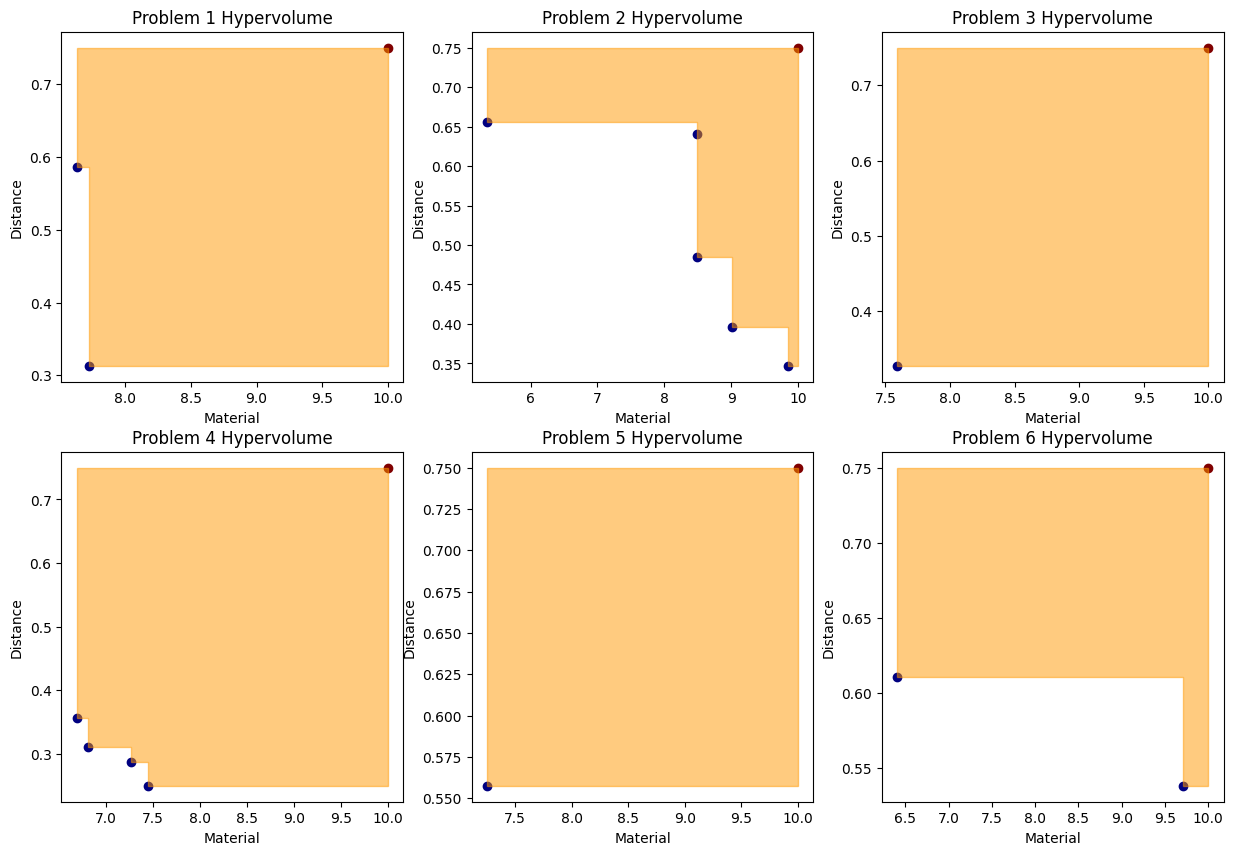

In [314]:
# Pareto front hypervolume visualizer
ga_visualizer = GAVisualizer()
plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(target_curves)):
    if isinstance(full_results[f'Problem {i+1}'], list) or full_results[f'Problem {i+1}'].X is None:
        print(f'Did Not Find Solutions for Problem {i+1}!!')
        plt.subplot(2, 3, i+1)
        plt.text(0.5, 0.5, 'No Solutions Found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
        continue
    ga_visualizer.plot_HV(
        F=full_results[f'Problem {i+1}'].F,
        ref=np.array([0.75, 10.0]),
        ax=plt.subplot(2, 3, i+1),
        objective_labels=['Distance', 'Material']
    )
    plt.title(f'Problem {i+1} Hypervolume')

In [315]:
# Compare and save scores
scores = evaluate_submission(submission)

overall_score = scores.get('Overall Score', 0)
problem_scores = [scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(scores['Score Breakdown']))]

print(f"Overall Score: {overall_score:.3f}")
print(f"Per Problem Scores: {problem_scores}")

best_submission = np.load('GTA_full_submission.npy', allow_pickle=True).item()
best_scores = evaluate_submission(best_submission)

# Compare and update the best scores if necessary
for i, (current_score, best_score) in enumerate(zip(problem_scores, best_scores['Score Breakdown'].values())):
    if current_score > best_score:
        best_submission[f'Problem {i+1}'] = submission[f'Problem {i+1}']
        print(f"Problem {i} improved! Was: {best_score}")

submission_filename = 'GTA_full_submission.npy'
best_submission['Overall Score'] = np.mean(list(evaluate_submission(best_submission)['Score Breakdown'].values()))
np.save(submission_filename, best_submission)

best_scores = evaluate_submission(best_submission)
b_overall_score = best_scores.get('Overall Score', 0)
b_problem_scores = [best_scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(best_scores['Score Breakdown']))]
print(f"Best Overall Score: {b_overall_score:.3f}")
print(f"Best Per Problem Scores: {b_problem_scores}")

Overall Score: 0.913
Per Problem Scores: [1.009914117219978, 0.7910402965337369, 1.016796533336617, 1.60965915571564, 0.5287591880687614, 0.5211853323510809]
Best Overall Score: 4.522
Best Per Problem Scores: [5.711237023963232, 3.7580908677527987, 4.719342835128515, 5.01041226447558, 4.078914303284899, 3.8532109239265875]
